## 베어링 이상탐지

- 베어링에서 진동 센서로 측정되는 값을 통해, 이상탐지를 하고자 함.
- 사용 모델 : autoencoder neural network  ( LSTM으로 구현 )
- 데이터세트 : 4개의 고장난 베어링에 대한 NASA 음향 및 진동 DB의 진동 센서 판독값

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True) # 팔레트 사용 여부 
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import joblib

# STEP1. Data loading

## Pre-processing 1.
- 분석에서 10분마다 하나의 데이터 포인트를 사용 (아래에서 데이터를 보면 10분간격임을 알 수 있음.)
- 해당 데이터의 값들은 20,480개의 데이터포인트에서 기록된 진동값의 절대값의 평균값을 사용하였음

In [3]:
### 데이터를 들고와서 DataFrame 형태로 가공

seed(10)
tf.random.set_seed(10)

data_dir = 'data/bearing_data' 
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    
    # 10분 마다 기록된 데이터중 한개에 대한 
    if filename == "2004.02.12.10.52.39":
        print(dataset)
    dataset_mean_abs = np.array(dataset.abs().mean()) # 절대값의 평균값
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename] # 맨 좌측 인덱스 추가
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

print("-"*50)
print(merged_data)

       0.112  -0.010  -0.005  0.022
0      0.049  -0.012  -0.046  0.020
1     -0.027  -0.017  -0.012  0.098
2     -0.110   0.029   0.112  0.056
3      0.007  -0.024  -0.044  0.054
4      0.122   0.051  -0.007 -0.012
...      ...     ...     ...    ...
20474 -0.125   0.000  -0.112 -0.017
20475 -0.024   0.151   0.161 -0.037
20476 -0.068   0.151   0.044 -0.042
20477 -0.105   0.083   0.002 -0.046
20478 -0.010  -0.076   0.146  0.022

[20479 rows x 4 columns]
--------------------------------------------------
                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004.02.12.10.52.39   0.060236   0.074227   0.083926   0.044443
2004.02.12.11.02.39   0.061455   0.073844   0.084457   0.045081
2004.02.12.11.12.39   0.061361   0.075609   0.082837   0.045118
2004.02.12.11.22.39   0.061665   0.073279   0.084879   0.044172
2004.02.12.11.32.39   0.061944   0.074593   0.082626   0.044659
...                        ...        ...        ...        ...
2004.02.19.05.42.39   0.453335   0.161016  

In [4]:
### 맨 좌측 인덱스를 날짜형식으로 변환

merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


## Pre-processing 2. Define train/test data
- 학습 / 테스트 데이터로 분할
- 베어링의 기계적 열화는 시간이 지남에 따라 점진적으로 발생한다고 가정

In [5]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


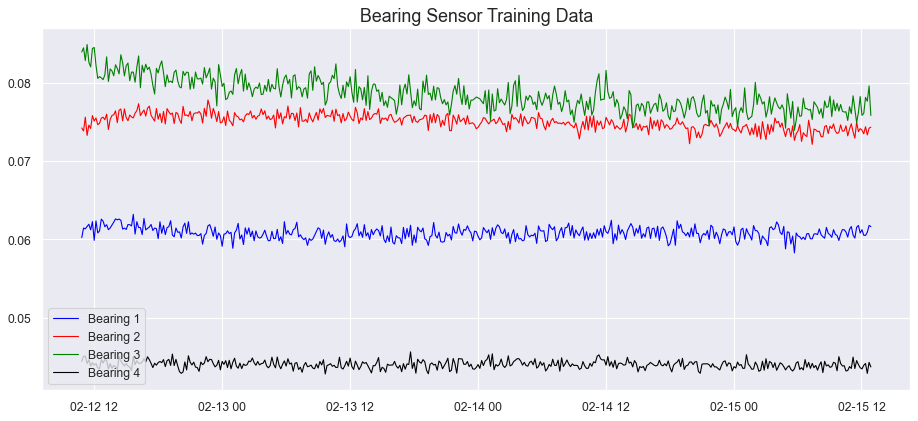

In [6]:
### Time Domain 에서의 학습데이터 출력

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

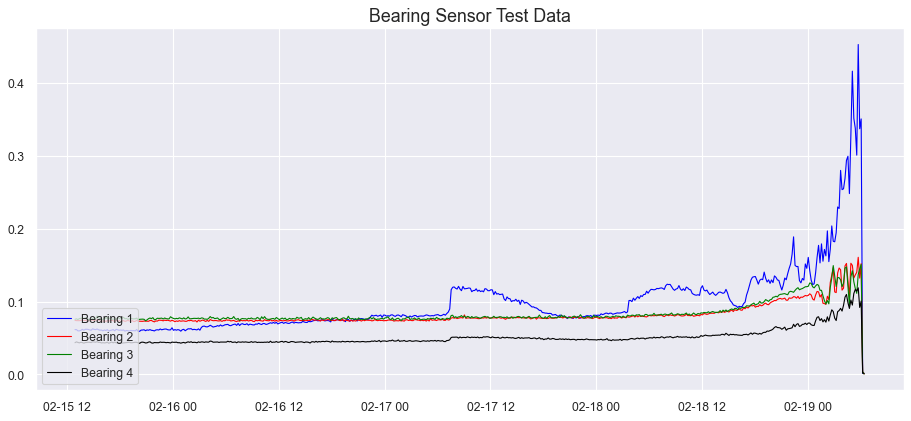

In [7]:
### Time Domain 에서의 테스트 데이터 출력
# 베어링의 기계적 열화는 시간이 지남에 따라 점진적으로 발생한다고 가정하였음
# 따라서 테스트 데이터 후반부에서 데이터의 형태가 노이즈가 심한 모습이 보임

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Data', fontsize=16)
plt.show()

## Pre-processing 3. 데이터 정규화
- 데이터 전처리를 완료하기 위해 먼저 데이터를 0과 1 사이의 범위로 정규화
- 그런 다음 LSTM 네트워크에 입력하기에 적합한 형식으로 데이터를 재구성

In [11]:
### 정규화

# train과 test 데이터를 정규화함
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [12]:
### LSTM 에 입력하기위한 형태로 재구성

# [samples, timesteps, features]

# 변경 전
# X_train.shape = (445,4)
# X_test.shape = (538,4)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


# STEP2. 모델 설정
- LSTM을 이용해서 오토인코더 모델 정의

In [13]:
### 오토인코더 모델 설정
# autoencoder_model에 들어올 변수는 X_train

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [14]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae') # Mean Absoulter Error
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68    

# STEP3. 학습
- 위에서 구성된 LSTM 모델을 통과시켜 학습데이터에 대해 학습 진행

In [15]:
### 학습 진행 

nb_epochs = 100 
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 3s 24ms/step - loss: 0.4454 - val_loss: 0.3190
Epoch 2/100
43/43 [==============================] - 1s 19ms/step - loss: 0.3812 - val_loss: 0.2455
Epoch 3/100
43/43 [==============================] - 1s 20ms/step - loss: 0.2909 - val_loss: 0.1621
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1620 - val_loss: 0.1683
Epoch 5/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1152 - val_loss: 0.1406
Epoch 6/100
43/43 [==============================] - 1s 21ms/step - loss: 0.1073 - val_loss: 0.1225
Epoch 7/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1035 - val_loss: 0.1154
Epoch 8/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1019 - val_loss: 0.1141
Epoch 9/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1013 - val_loss: 0.1147
Epoch 10/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1010 - val_loss: 0.1134

43/43 [==============================] - 1s 20ms/step - loss: 0.0936 - val_loss: 0.0935
Epoch 83/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0938 - val_loss: 0.0938
Epoch 84/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0937 - val_loss: 0.0930
Epoch 85/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0937 - val_loss: 0.0924
Epoch 86/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0935 - val_loss: 0.0941
Epoch 87/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0940 - val_loss: 0.0928
Epoch 88/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0941 - val_loss: 0.0928
Epoch 89/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0938 - val_loss: 0.0933
Epoch 90/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0938 - val_loss: 0.0924
Epoch 91/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0938 - val_loss: 0.0919
Epo

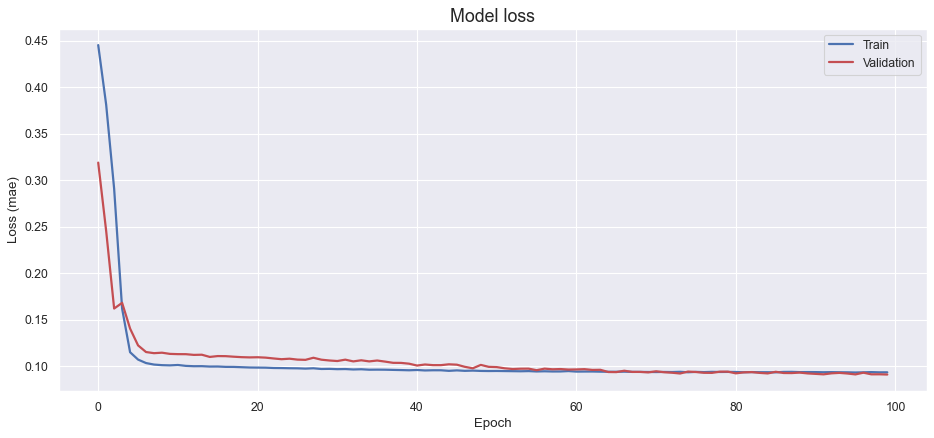

In [16]:
### training loss 출력

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# STEP4. 예측 및 테스트
- 학습데이터에 대한 예측값 확인 및 MAE 값 시각화
- 이상탐지 Threshold 값을 설정

#### 학습데이터로 확인

In [17]:
X_pred = model.predict(X_train) # (445,1,4)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) # (445,4)
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index
print(X_pred)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-12 10:52:39   0.598788   0.665105   0.610904   0.509486
2004-02-12 11:02:39   0.622378   0.700160   0.669623   0.531915
2004-02-12 11:12:39   0.649844   0.738470   0.738637   0.557421
2004-02-12 11:22:39   0.599499   0.666190   0.612665   0.510169
2004-02-12 11:32:39   0.610114   0.682181   0.639024   0.520315
...                        ...        ...        ...        ...
2004-02-15 12:12:39   0.397009   0.292807   0.197805   0.305900
2004-02-15 12:22:39   0.487262   0.462176   0.339904   0.397209
2004-02-15 12:32:39   0.408665   0.314560   0.215409   0.317878
2004-02-15 12:42:39   0.526910   0.546726   0.436719   0.438184
2004-02-15 12:52:39   0.430221   0.354668   0.248032   0.339844

[445 rows x 4 columns]


In [18]:
### 데이터프레임에 MAE 추가

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) # (445,1,4) -> (445,4)

scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1) 
print(scored)

                     Loss_mae
2004-02-12 10:52:39  0.215275
2004-02-12 11:02:39  0.243620
2004-02-12 11:12:39  0.119261
2004-02-12 11:22:39  0.244114
2004-02-12 11:32:39  0.165220
...                       ...
2004-02-15 12:12:39  0.050079
2004-02-15 12:22:39  0.055044
2004-02-15 12:32:39  0.160750
2004-02-15 12:42:39  0.133140
2004-02-15 12:52:39  0.094947

[445 rows x 1 columns]


C:\Users\infosec\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

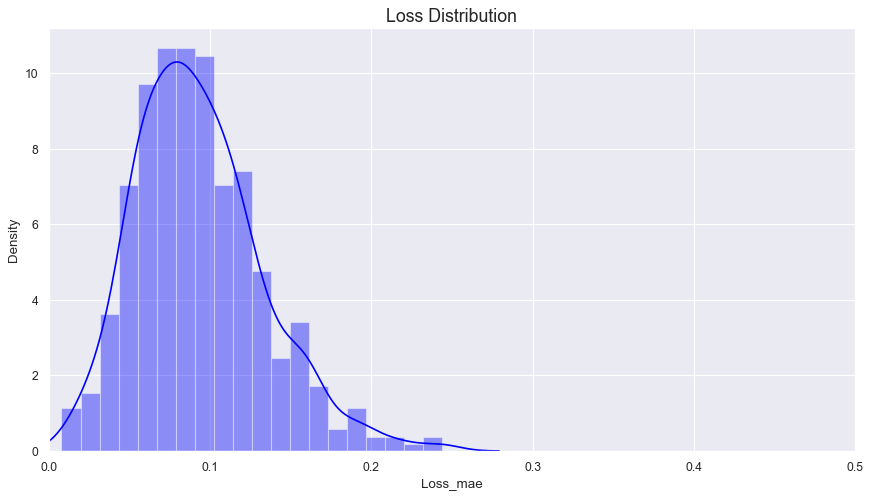

In [19]:
### MAE 값 출력 (histogram)

plt.figure(figsize=(13,7), dpi=80)
plt.title('Loss Distribution', fontsize=16)

# 임계값을 정하기위해 histogram을 통해 데이터 분포확인
# 데이터의 분포 형태를 얻기 위해 kde = True 설정 
# kDE (Kernel Density Estimator)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue'); 
plt.xlim([0.0,.5])

In [20]:
### 데이터프레임에 Threshold / Anomaly 추가

scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold'] # MAE 값이 Threshold보다 크면 True
print(scored)

                     Loss_mae  Threshold  Anomaly
2004-02-12 10:52:39  0.215275      0.275    False
2004-02-12 11:02:39  0.243620      0.275    False
2004-02-12 11:12:39  0.119261      0.275    False
2004-02-12 11:22:39  0.244114      0.275    False
2004-02-12 11:32:39  0.165220      0.275    False
...                       ...        ...      ...
2004-02-15 12:12:39  0.050079      0.275    False
2004-02-15 12:22:39  0.055044      0.275    False
2004-02-15 12:32:39  0.160750      0.275    False
2004-02-15 12:42:39  0.133140      0.275    False
2004-02-15 12:52:39  0.094947      0.275    False

[445 rows x 3 columns]


<AxesSubplot:>

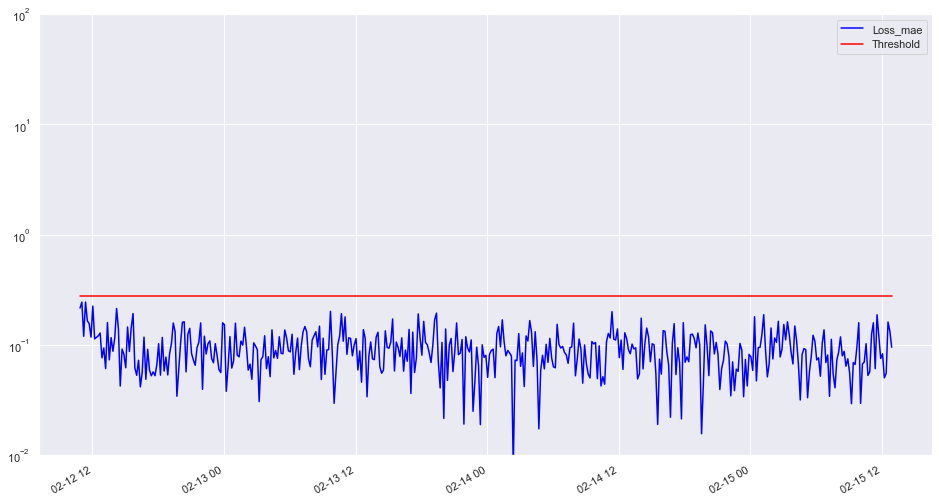

In [21]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

#### 테스트 데이터로 확인

In [22]:
X_pred = model.predict(X_test) # (538,1,4)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) # (538,4)
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index
print(X_pred)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-15 12:52:39   0.430221   0.354668   0.248032   0.339844
2004-02-15 13:02:39   0.457320   0.404820   0.289141   0.367122
2004-02-15 13:12:39   0.398818   0.296185   0.200535   0.307763
2004-02-15 13:22:39   0.414846   0.326079   0.224756   0.324201
2004-02-15 13:32:39   0.466556   0.421836   0.303173   0.376334
...                        ...        ...        ...        ...
2004-02-19 05:42:39   2.022167  -2.961075  11.002131   0.651422
2004-02-19 05:52:39   1.581372  -1.671793   8.518726   0.459839
2004-02-19 06:02:39   1.802009  -2.306501   9.771687   0.554046
2004-02-19 06:12:39   0.289867   0.104645   0.041412   0.194567
2004-02-19 06:22:39   0.289444   0.103996   0.040796   0.194119

[538 rows x 4 columns]


In [23]:
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2]) # (538,1,4) -> (538,4)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275

# MAE 값이 Threshold보다 크면 True
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

                      Loss_mae  Threshold  Anomaly
2004-02-15 12:52:39   0.094947      0.275    False
2004-02-15 13:02:39   0.171298      0.275    False
2004-02-15 13:12:39   0.068595      0.275    False
2004-02-15 13:22:39   0.053266      0.275    False
2004-02-15 13:32:39   0.038586      0.275    False
...                        ...        ...      ...
2004-02-19 05:42:39  32.133567      0.275     True
2004-02-19 05:52:39  21.641825      0.275     True
2004-02-19 06:02:39  24.226598      0.275     True
2004-02-19 06:12:39  11.290696      0.275     True
2004-02-19 06:22:39  11.530932      0.275     True

[538 rows x 3 columns]


<AxesSubplot:>

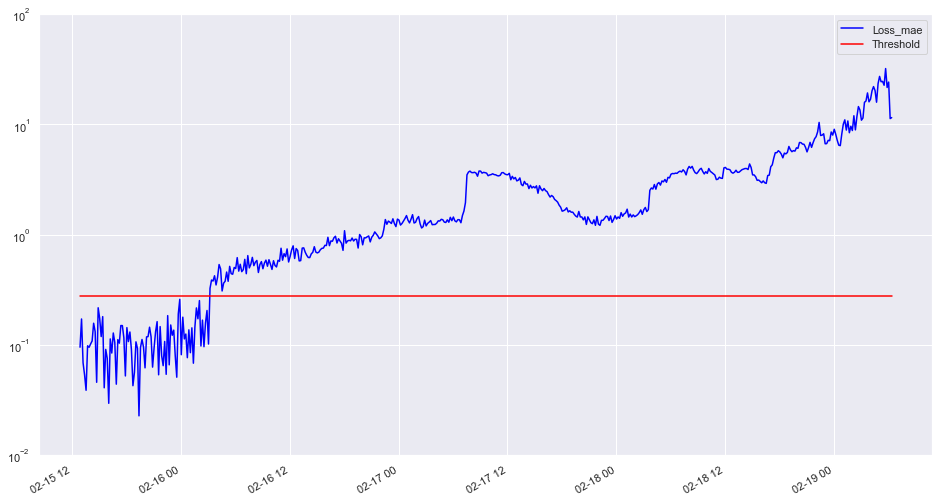

In [24]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

#### 모델 정보 저장

In [25]:
model.save("Cloud_model.h5")
print("Model saved")

Model saved
